In [7]:
import os
os.chdir('/content/drive/MyDrive/COVID Vaccine Instagram Analysis/FINAL PROJECT DELIVERABLES/Code')

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer

os.chdir('/content/drive/MyDrive/COVID Vaccine Instagram Analysis/Original Project')

df = pd.read_csv('final_total_data.csv')

# Create NLP- DF & CSR
vectorizer = TfidfVectorizer()
df_vectorized = vectorizer.fit_transform(df.clean_cap)
features = vectorizer.get_feature_names()
instances = df_vectorized.toarray()
df_nlp = pd.DataFrame(columns=features, data=instances) #Dense version of CSR Matrix
csr_nlp = scipy.sparse.csr_matrix(df_nlp.values)

In [ ]:
df

In [ ]:
# Def a Corpus & Dictionary
import pickle
from gensim import corpora


text_tokens = [[text for text in cap.split()] for cap in df.clean_cap]

dictionary = corpora.Dictionary(text_tokens)
corpus = [dictionary.doc2bow(text) for text in text_tokens]
print(dictionary.token2id)
print(corpus)

# Make Corpus Readable
id_words = [[(dictionary[id], count) for id, count in line] for line in corpus]
print(id_words)

# Save Corpus / Dict
pickle.dump(corpus, open('corpus_BagOfWords.pkl', 'wb'))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Train LDA Model
from gensim.models.ldamodel import LdaModel

n_topics = 20
lda_model = LdaModel(corpus=corpus, id2word=dictionary
                     , num_topics=n_topics
                     , alpha='auto'
                     , chunksize=500
                     , random_state=7 )

In [ ]:
import pprint as p
p.pprint(lda_model.print_topics())

In [ ]:
out[:][:] #get item from list

10

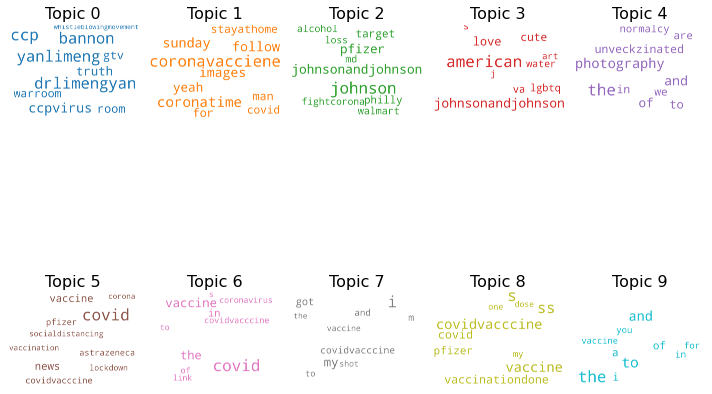

In [ ]:
# WordCloud per Topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
# Plot Topic Words & Frequency
from collections import Counter
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in text_tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_1 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_1.loc[df_1.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_1.loc[df_1.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_1.loc[df_1.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [ ]:
# t-SNE Clustering Visualization
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    print(row_list)
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

# Start Corex Topic Modeling

LDA did not work as well but we have an idea of the topics that are present from pyLDAvis (when it worked) as well as WordCloud visualizations of the LDA models above

In [ ]:
# Create Doc-Term Matrix for Corex
import scipy.sparse as ss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 


my_additional_stop_words = ['vaccine', 'sunday', 'covid', 'coronatime', 'vaccination', 'corona', 'covidvacccine', 'time', 'make', 'know'
                            # Hamilton Related Topic Words
                          , 'hamilton', 'hamiltonmemes', 'alexanderhamilton', 'linmanuelmiranda', 'aaronburr', 'andpeggy', 'leslieodomjr', 'meme', 'anthonyramos', 'daveeddiggs'
                          , 'angelicaschuyler', 'riseup', 'theater', 'originalbroadwaycast', 'phillipasoo', 'obc', 'elizahamilton'
                          , 'broadwaymemes', 'theaterkid', 'pippasoo', 'removal', 'hammyspammy', 'hamilspamilton', 'noticemesenpai', 'hamiltonobc'
                          , 'healthcare', 'stayhome', 'hamilspam', 'hamiltonensemble', 'vaccinesafetyadvocate', 'wellness'
                          , 'hamiltonbroadway'
                            #J&J Baby Products
                          , 'babiesoftiktok', 'babyboy', 'babyfashion', 'babyclothes', 'skin', 'tousruskid', 'vansoffthewall', 'babytoys', 'toysrus'
                          , 'converse', 'igmodel', 'babyfeet', 'buybuybaby', 'toys', 'babymodel'
                          , 'babyfever', 'babyphotography', 'powder'
                          
                            #Misc Words
                          , 'fortlauderdale', 'cdc', 'trials', 'people', 'feel', 'need', 'things', 'way'
                          , 'nd', 'com', 'https', 'link', 'www', 'use', 'ss'
                          , 'retro', 'vintage', 'biontech', 'vaccinate', 'vaccinationdone', 'vaccines', 'information', 'tampa', 'lockdown', 'arm', 'got', 'today'
                          , 'walmart', 'like', 'day', 'later', 'target'
                          , 'dm', 'goochland', 'peeled', 'model', 'adidas', 'vans', 'firstdosedone', 'messages', 'hrs', 'florida', 'say'
                          , 'polo', 'blueeyes', 'oan', 'clinics', 'coincidentally', 'apart', 'nurse', 'getting', 'high', 'saturday', 'fresh'
                          , 'think', 'event', 'quarantinelife', 'beautiful'
                           ]
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

vectorizer = CountVectorizer(stop_words=stop_words, max_features=20000, binary=True, max_df=.60, min_df=2)
doc_word = vectorizer.fit_transform(df['token_cap'].astype('U')) #Learn the vocabulary dictionary and return term-document matrix.
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words


# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(3971, 10604)

In [ ]:
!pip install corextopic #Run with each kernel -- for below

In [ ]:
# Corex Topic Modeling
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

#topic_model = ct.Corex(n_hidden=10, words=words, max_iter=200, verbose=False, seed=1) # OLD VERSION USE ANCHOR WORDs FOR ANALYSIS
#topic_model.fit(doc_word, words=words); #training model takes a while, use below for Viz

# def AnchorWords
anchor_words = [['ccpvirus', 'yanlimeng', 'drlimengyan', 'bannon', 'whistleblowingmovement']
                , ['johnsonandjohnson', 'j', 'jandj']
                , ['pfizer', 'pfizervacine']
                , ['moderna', 'mrna', 'modernavaccice']
                , ['astrazeneca']
                , ['normalcy']
                , ['week', 'allergic', 'reaction', 'felt', 'dose', 'shot']
               ]

# Anchored CoRex Model
topic_model_anchored = ct.Corex(n_hidden=8, seed=1)
topic_model_anchored.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);
#mess with dif values of anchor strength (greater->more like supervised learing)

In [ ]:
curr_model_topics = topic_model_anchored.get_topics()
curr_model_topics

# Words to remove

# Hamilton to remove -- a prominent topic within the data that was not useful for our purposes


In [ ]:
# Visualize Corex Model
vt.vis_rep(topic_model_anchored, column_label=words, prefix='CorexViz') #saves several docs in a folder in current directory

Print topics in text file


In [ ]:
ls

'Concated posts_data -- size5714.csv'   final_total_data.csv
'Concate_NLP & Image_Data.ipynb'        Get_Images.ipynb
 CorexViz/                             'image analysis'/
 corpus_BagOfWords.pkl                  Image_NLP_Data.gsheet
 Data/                                  Links_Consolidate.ipynb
 Data_Scrape.ipynb                      NLP/
'Executive Summary.gdoc'                NLP_Filtered_Data.csv
 Exploratory_Analysis.ipynb             Old/
 final_indiv_data.csv                   tableau.twb
 final_org_data.csv                     Topic_Modeling.ipynb
'Final Presentation - 506.pptx'         topics/
'FINAL PROJECT DELIVERABLES'/


In [ ]:
# From first iteration with anchor words & Default stops
prev_model_topics = topic_model_anchored.get_topics()
prev_model_topics

[[('ccpvirus', 0.31885990083808435, 1.0),
  ('drlimengyan', 0.31207507918191335, 1.0),
  ('bannon', 0.31207507918191335, 1.0),
  ('whistleblowingmovement', 0.31207507918191335, 1.0),
  ('yanlimeng', 0.31207507918191335, 1.0),
  ('policebrutalityhk', 0.05201251319698556, 1.0),
  ('takedowntheccp', 0.05201251319698556, 1.0),
  ('unrestrictedbioweapon', 0.05201251319698556, 1.0),
  ('unrestrictedscientificmisinformation', 0.05201251319698556, 1.0),
  ('savehongkong', 0.05201251319698556, 1.0)],
 [('johnsonandjohnson', 3.432476333126396, 1.0),
  ('powder', 0.041302694154550804, 1.0),
  ('johnson', 0.03276525862370088, 1.0),
  ('oneanddone', 0.0166359988520743, 1.0),
  ('babyboy', 0.014193756977269609, 1.0),
  ('babyfashion', 0.012751536879234375, 1.0),
  ('babyclothes', 0.011382101840079789, 1.0),
  ('skin', 0.010673715234922027, 1.0),
  ('iamnotthrowingawaymyshot', 0.009925592465789248, -1.0),
  ('babiesoftiktok', 0.009873998302895325, 1.0)],
 [('pfizer', 3.306606214065255, 1.0),
  ('pfiz

# pyLDAvis Visualization of Topics?

Even with help from harsh recieved same error, seems to be a difference in the versions of Numpy / Pandas and pyLDAvis, specifically throwing an error on one of the functions with a library. Have spent many hours trying to remidate this to no avail

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 3.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 26.1MB/s 
     |████████████████████████████████| 15.3MB 279kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=269e5893b485e7e218b7d6b1748f6623c291da77e3dd2f94bcf5fa35f3b3b2a3
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

In [ ]:
# pyLDAvis Package
import pyLDAvis
import pyLDAvis.gensim_models

vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, 
                              corpus=corpus, 
                              dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

AttributeError: ignored

In [ ]:
# Harsh's Method for pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation

topic_model_vis = LatentDirichletAllocation(n_components=20, max_iter=30, random_state=7)
topic_model_vis.fit(doc_word)

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(topic_model_vis, doc_word, vectorizer, mds='tsne')
panel

ImportError: ignored

In [ ]:
!cat /usr/local/lib/python3.7/dist-packages/pandas/core/computation/check.py

from pandas.compat._optional import import_optional_dependency

ne = import_optional_dependency("numexpr", raise_on_missing=False, on_version="warn")
NUMEXPR_INSTALLED = ne is not None
if NUMEXPR_INSTALLED:
    NUMEXPR_VERSION = ne.__version__
else:
    NUMEXPR_VERSION = None

__all__ = ["NUMEXPR_INSTALLED", "NUMEXPR_VERSION"]


In [ ]:
# Corex Viz Functions from Github
# Link- https://github.com/gregversteeg/bio_corex/blob/master/vis_corex.py